# MRI Volume Registration using Affine Transforms and Wavelet Scattering
EE 678, Group 22


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kymatio import Scattering2D
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk

### Loading the data files

In [2]:
# Load the NIfTI file
month1 = nib.load('anita_1.nii')
month1_data = month1.get_fdata()
month1_data = month1_data/np.max(month1_data)

month3 = nib.load('anita_3.nii')
month3_data = month3.get_fdata()
month3_data = month3_data/np.max(month3_data)

# Load the bone masks (from k-means clustering)
bone_mask_month_1 = nib.load('./saved-data/bone_mask_month_1.nii').get_fdata()
bone_mask_month_3 = nib.load('./saved-data/bone_mask_month_3.nii').get_fdata()

### Visualize a slice

In [3]:
# Set a global index for slicing
index =120

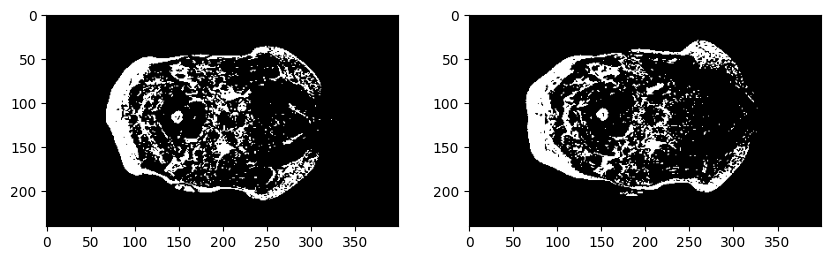

In [4]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(bone_mask_month_1[:,:,index], cmap='gray')
ax[1].imshow(bone_mask_month_3[:,:,index], cmap='gray')

In [5]:
# Obtain masked bone images
masked_bone_month_1 = month1_data * bone_mask_month_1
masked_bone_month_3 = month3_data * bone_mask_month_3

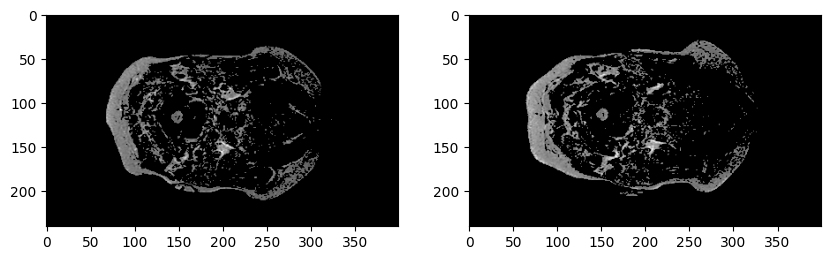

In [6]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(masked_bone_month_1[:,:,index], cmap='gray')
ax[1].imshow(masked_bone_month_3[:,:,index], cmap='gray')

## Rigid Registration

In [7]:
# Function to convert numpy array to SimpleITK image
def numpy_to_sitk(image_np):
    return sitk.GetImageFromArray(image_np)

# Function to convert SimpleITK image to numpy array
def sitk_to_numpy(image_sitk):
    return sitk.GetArrayFromImage(image_sitk)

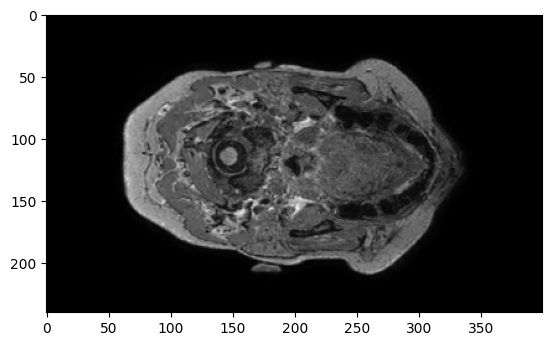

In [8]:
reference_image = numpy_to_sitk(masked_bone_month_1)
moving_image = numpy_to_sitk(masked_bone_month_3)

# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Set metric, optimizer, and interpolator for the registration
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, numberOfIterations=100000)
registration_method.SetInterpolator(sitk.sitkLinear)

# Set the initial transformation as a rigid transformation
initial_transform = sitk.CenteredTransformInitializer(reference_image,
                                                      moving_image,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform = registration_method.Execute(reference_image, moving_image)

# Apply the transformation to a different 3D matrix
new_moving_np = month3_data
new_reference_np = month1_data
new_reference_image = numpy_to_sitk(new_reference_np)
new_moving_image = numpy_to_sitk(new_moving_np)
transformed_image = sitk.Resample(new_moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

# Convert the transformed image back to a numpy array
transformed_np = sitk_to_numpy(transformed_image)
registered_month_3 = transformed_np

# transformed_np now contains the transformed 3D matrix of the new input
plt.imshow(transformed_np[:,:,index], cmap='gray')

# Save the transformation to a file (optional)
# sitk.WriteTransform(final_transform, "rigid_transform.tfm")

# If you want to load and apply the saved transform
# loaded_transform = sitk.ReadTransform("rigid_transform.tfm")
# transformed_image_with_loaded_transform = sitk.Resample(new_moving_image, reference_image, loaded_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())
# transformed_np_with_loaded_transform = sitk_to_numpy(transformed_image_with_loaded_transform)

Text(0.5, 1.0, 'Registered Month 3')

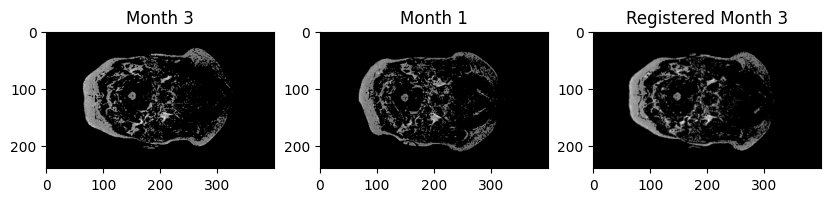

In [24]:
# apply the final transformation to moving image and reference image
transformed_image_bone = sitk.Resample(moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
transformed_np_bone = sitk_to_numpy(transformed_image_bone)
fig,ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(masked_bone_month_3[:,:,index], cmap='gray')
ax[0].set_title('Month 3')
ax[1].imshow(masked_bone_month_1[:,:,index], cmap='gray')
ax[1].set_title('Month 1')
ax[2].imshow(transformed_np_bone[:,:,index], cmap='gray')
ax[2].set_title('Registered Month 3')


In [22]:
## Compute correlation between month 1 bone and month 3 bone and month 1 bone and month 3 bone after registration
correlation_before = np.corrcoef(masked_bone_month_1.flatten(), masked_bone_month_3.flatten())
correlation_after = np.corrcoef(masked_bone_month_1.flatten(), transformed_np_bone.flatten())
print("Correlation between Month 1 and Month 3 bones (original):",correlation_before[0,1])
print("Correlation between Month 1 and registered Month 3 bones:",correlation_after[0,1])

Correlation between Month 1 and Month 3 bones (original): 0.4588571649909216
Correlation between Month 1 and registered Month 3 bones: 0.6007886088217184


In [23]:
# computer MSE of bones
mse_before = np.mean((masked_bone_month_1 - masked_bone_month_3)**2)
mse_after = np.mean((masked_bone_month_1 - transformed_np_bone)**2)
print("MSE between Month 1 and Month 3 bones (original):", mse_before)
print("MSE between Month 1 and registered Month 3 bones:", mse_after)

MSE between Month 1 and Month 3 bones (original): 0.016902574110838117
MSE between Month 1 and registered Month 3 bones: 0.011683556978720701


## Registration Improvement Metrics 

Text(0.5, 1.0, 'Month 3 Transformed to Month 1')

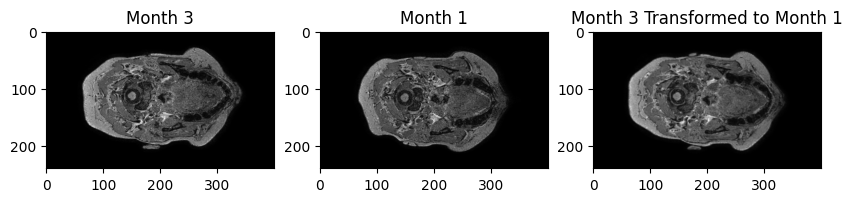

In [9]:
fig,ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(new_moving_np[:,:,index], cmap='gray')
ax[0].set_title('Month 3')
ax[1].imshow(new_reference_np[:,:,index], cmap='gray')
ax[1].set_title('Month 1')
ax[2].imshow(transformed_np[:,:,index], cmap='gray')
ax[2].set_title('Month 3 Transformed to Month 1')

### Cross Correlation

#### Cross Correlation between Month 1, Month 3 and Registered Month 3 volumes

In [10]:
# find correlation bwteen month 1 and registered month 3
correlation_vol_old = np.corrcoef(new_reference_np.flatten(), new_moving_np.flatten())[0,1]
print('Correlation between month 1 and month 3 (original):', correlation_vol_old)
# find correlation bwteen month 1 and month 3
correlation_vol_new = np.corrcoef(new_reference_np.flatten(), registered_month_3.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_vol_new)

Correlation between month 1 and month 3 (original): 0.7569567879685091
Correlation between month 1 and registered month 3: 0.8253318243249755


#### Cross Correlation between slice of Month 1, Month 3 and Registered Month 3 volumes

In [25]:
month1img = new_reference_np[:,:,index]
month3img = new_moving_np[:,:,index]
registered_month3img = registered_month_3[:,:,index]

# correlation between images
correlation_old = np.corrcoef(month1img.flatten(), month3img.flatten())[0,1]
print('Correlation between month 1 and month 3:', correlation_old)
correlation_new = np.corrcoef(month1img.flatten(), registered_month3img.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_new)

Correlation between month 1 and month 3: 0.7710995545510168
Correlation between month 1 and registered month 3: 0.8131195362875392


#### Cross Correlation between  wavelet scattering transform coefficients of a slice of Month 1, Month 3 and Registered Month 3 volumes

In [12]:
# Compute the scattering coefficients
scattering = Scattering2D(J=2, shape=month1img.shape)
scattering_month1 = scattering(month1img)
scattering_month3 = scattering(month3img)
scattering_registered_month3 = scattering(registered_month3img)

In [13]:
# compute correlation between scattering coefficients
normalized_scattering_month1 = scattering_month1/np.max(scattering_month1)
normalized_scattering_month3 = scattering_month3/np.max(scattering_month3)
normalized_scattering_registered_month3 = scattering_registered_month3/np.max(scattering_registered_month3)
threshold = 0.2
# thres

correlation_scatter_old = np.corrcoef(normalized_scattering_month1.flatten(), normalized_scattering_month3.flatten())[0,1]
print('Correlation between month 1 and month 3:', correlation_scatter_old)
correlation_scatter_new = np.corrcoef(normalized_scattering_month1.flatten(), normalized_scattering_registered_month3.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_scatter_new)


Correlation between month 1 and month 3: 0.9000162696330142
Correlation between month 1 and registered month 3: 0.9212683051599244


#### Improvement in Correlation

In [14]:
# percentage increase in coorelation
percentage_increase = (correlation_scatter_new - correlation_old)/correlation_old * 100
print('Percentage increase in correlation:', percentage_increase)

Percentage increase in correlation: 19.474625516590457


### Mean Squared Error (MSE)

#### MSE between wavelet scattering transform coefficients of a slice of Month 1, Month 3 and Registered Month 3 volumes

In [15]:
# compute mean squared error between scattering coefficients
mse_og = np.mean((normalized_scattering_month1 - normalized_scattering_month3)**2)
print('Mean Squared Error between month 1 and month 3:', mse_og)
mse_new = np.mean((normalized_scattering_month1 - normalized_scattering_registered_month3)**2)
print('Mean Squared Error between month 1 and registered month 3:', mse_new)

# % reduction in MSE
mse_reduction = (mse_og - mse_new)/mse_og * 100
print('Percentage reduction in MSE:', mse_reduction,'%')

Mean Squared Error between month 1 and month 3: 0.00021452421067815142
Mean Squared Error between month 1 and registered month 3: 0.0001675291851926183
Percentage reduction in MSE: 21.906630182660038 %


#### MSE between wavelet scattering transform coefficients of a slice of Month 1, Month 3 and Registered Month 3 volumes

In [16]:
# thresholded MSE
difference_og = np.abs(normalized_scattering_month1 - normalized_scattering_month3)
thresholded_difference_og = np.where(difference_og > threshold, difference_og, 0)
mse_og = np.mean(thresholded_difference_og**2)
difference_new = np.abs(normalized_scattering_month1 - normalized_scattering_registered_month3)
thresholded_difference_new = np.where(difference_new > threshold, difference_new, 0)
mse_new = np.mean(thresholded_difference_new**2)
print('Mean Squared Error between month 1 and month 3 (thresholded):', mse_og)
print('Mean Squared Error between month 1 and registered month 3 (thresholded):', mse_new)
print('Percentage reduction in MSE (thresholded):', (mse_og - mse_new)/mse_og * 100,'%')

Mean Squared Error between month 1 and month 3 (thresholded): 0.00015387845311295778
Mean Squared Error between month 1 and registered month 3 (thresholded): 0.0001158481929798244
Percentage reduction in MSE (thresholded): 24.71448039916053 %


### Analysis of Boundaries

In [40]:
m1x, m1y, m1z = masked_bone_month_1.shape
m1constraints = {}
for i in range(m1x):
    if np.count_nonzero(masked_bone_month_1[i,:,:]):
        m1constraints['x']=[i]
        break
for i in range(m1x-1,0,-1):
    if np.count_nonzero(masked_bone_month_1[i,:,:]):
        m1constraints['x'].append(i)
        break
for i in range(m1y):
    if np.count_nonzero(masked_bone_month_1[:,i,:]):
        m1constraints['y']=[i]
        break
for i in range(m1y-1,0,-1):
    if np.count_nonzero(masked_bone_month_1[:,i,:]):
        m1constraints['y'].append(i)
        break
for i in range(m1z):
    if np.count_nonzero(masked_bone_month_1[:,:,i]):
        m1constraints['z']=[i]
        break
for i in range(m1z-1,0,-1):
    if np.count_nonzero(masked_bone_month_1[:,:,i]):
        m1constraints['z'].append(i)
        break

In [46]:
m3x, m3y, m3z = masked_bone_month_3.shape
m3constraints = {}
for i in range(m3x):
    if np.count_nonzero(masked_bone_month_3[i,:,:]):
        m3constraints['x']=[i]
        break
for i in range(m3x-1,0,-1):
    if np.count_nonzero(masked_bone_month_3[i,:,:]):
        m3constraints['x'].append(i)
        break
for i in range(m3y):
    if np.count_nonzero(masked_bone_month_3[:,i,:]):
        m3constraints['y']=[i]
        break
for i in range(m3y-1,0,-1):
    if np.count_nonzero(masked_bone_month_3[:,i,:]):
        m3constraints['y'].append(i)
        break
for i in range(m3z):
    if np.count_nonzero(masked_bone_month_3[:,:,i]):
        m3constraints['z']=[i]
        break
for i in range(m3z-1,0,-1):
    if np.count_nonzero(masked_bone_month_3[:,:,i]):
        m3constraints['z'].append(i)
        break

In [50]:
m3_reg_x, m3_reg_y, m3_reg_z = transformed_np_bone.shape
m3_reg_constraints = {}
for i in range(m3_reg_x):
    if np.count_nonzero(transformed_np_bone[i,:,:]):
        m3_reg_constraints['x']=[i]
        break
for i in range(m3_reg_x-1,0,-1):
    if np.count_nonzero(transformed_np_bone[i,:,:]):
        m3_reg_constraints['x'].append(i)
        break
for i in range(m3_reg_y):
    if np.count_nonzero(transformed_np_bone[:,i,:]):
        m3_reg_constraints['y']=[i]
        break
for i in range(m3_reg_y-1,0,-1):
    if np.count_nonzero(transformed_np_bone[:,i,:]):
        m3_reg_constraints['y'].append(i)
        break
for i in range(m3_reg_z):
    if np.count_nonzero(transformed_np_bone[:,:,i]):
        m3_reg_constraints['z']=[i]
        break
for i in range(m3_reg_z-1,0,-1):
    if np.count_nonzero(transformed_np_bone[:,:,i]):
        m3_reg_constraints['z'].append(i)
        break

In [52]:
print("Boundaries of Month 1 Volume:", m1constraints)
print("Bounderies of  Month 3 Volume:", m3constraints)
print("Bounderies of Registered Month 3 Volume:", m3_reg_constraints)

Boundaries of Month 1 Volume: {'x': [0, 239], 'y': [3, 352], 'z': [0, 374]}
Bounderies of  Month 3 Volume: {'x': [0, 239], 'y': [13, 355], 'z': [0, 377]}
Bounderies of Registered Month 3 Volume: {'x': [0, 239], 'y': [4, 353], 'z': [0, 379]}
